- iterate over the cells
- save hydrology and sediments
- make sure to save the ls, sc

1. Experiment 1: NO GLACIERS
2. Experiment 2: transport limited case (!!! HERE: calculate what is the mean annual sedimant yeild) 
3. Experiment 3: linear increase in sediment storage: (HOW BIG LANDSLIDE SHOULD BE?)

-- to make changes in the model go to run.py, SedCas_glacier_sed.py (model) or modules.py (modules)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# modelling part
from run import run


# all data is stored on the external ssd 
# example path:
# /Volumes/Extreme SSD/2024May_sedcas_modelruns/3mustangSL/default_land_cover_50percent




###  transport limited case (=sediment unlimited): calculate how much sediment there MAY be

In [ ]:
%%time
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover'
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/2bagrotTL/default_land_cover'
climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangTL/default_land_cover/'


# get all folders togetehr 
# ls_ = os.listdir('./langtang')
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()
# print(dir0)
# run the model for each
for d in ls:
    # path = os.path.join(dir0, '1langtangTL/default_land_cover', d)
    # path = os.path.join(dir0, '2bagrotTL/default_land_cover', d)
    path = os.path.join(dir0, '3mustangTL/default_land_cover', d)
    if path.endswith('.csv'):
        continue
    # print(path)
    os.chdir(path)
    run()
    os.chdir(dir0)


In [ ]:
# check if all folders have parameter files 

# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover'
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/2bagrotTL/default_land_cover'
climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangTL/default_land_cover'

# get all folders togetehr 
# ls_ = os.listdir('./langtang')
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()


# Assuming ls contains the list of folders
for d in ls:
    path = os.path.join(dir0, '3mustangTL/default_land_cover', d)
    if path.endswith('.csv'):
        continue
    
    parameter_file_exists = False  # Flag to track if parameter file exists
    
    for file in os.listdir(path):
        if file.endswith('.out') and 'Sediment.out' in file:
            parameter_file_exists = True
            break
    
    if not parameter_file_exists:
        print("sediment file not found in:", path[-3:])
        # You can add further actions here to flag the folder
        
    os.chdir(dir0)

In [ ]:
%%time

# only run for folders that do not already have sediment out file
climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangTL/default_land_cover/'

# Get all folders together
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()

# Iterate through each folder in ls
for d in ls:
    path = os.path.join(climatepath, d)  # Construct full path to the folder
    if os.path.isdir(path):  # Check if the path is a directory
        sediment_out_exists = os.path.exists(os.path.join(path, 'Sediment.out'))
        
        if not sediment_out_exists:
            # Add code to perform operations only if Sediment.out file doesn't exist
            if path.endswith('.csv'):
                continue
            os.chdir(path)
            run()
            os.chdir(dir0)
        else:
            print("already done:", path)


# how much sediment is exported per year in the transport limited case (= unlimited amount of sedoments) ?

In [ ]:
# for each output sediment folder calculate the total annual 
# go over each folder 
# take Sediment out file 
# calculate annual mean
# save into the table, where the table has: cellnr, mean annual sed yeald

In [ ]:

# Define your custom function
def annual_sum_mean(df):
    df['D'] = pd.to_datetime(df['D'])
    df['Year'] = df['D'].dt.year
    annual_sum = df.groupby('Year').sum()
    annual_mean_Qstl = annual_sum.Qstl.mean()
    return annual_mean_Qstl

def annual_sum_percentile(df, percentile):
    df['D'] = pd.to_datetime(df['D'])
    df['Year'] = df['D'].dt.year
    annual_sum = df.groupby('Year').sum()
    annual_percentile_Qstl = annual_sum.Qstl.quantile(percentile / 100)
    return annual_percentile_Qstl


In [ ]:
%%time
# 1- langtang
# 2 - bagrot
# 3 - mustang

# Path to the directory containing your folders
# directory_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover'
directory_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/2bagrotTL/default_land_cover'
directory_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangTL/default_land_cover'

mean_annual_sum =[]

mean_annual_10 = []
mean_annual_20 = []
mean_annual_25 = []
mean_annual_30 = []
mean_annual_40 = []
mean_annual_50 = []
mean_annual_60 = []
mean_annual_70 = []
mean_annual_75 = []
mean_annual_80 = []
mean_annual_90 = []
mean_annual_100 = []


# Iterate over each folder
for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    
    # Check if it's a directory and its name starts with 'cellnr'
    if os.path.isdir(folder_path): #and folder_name.startswith('cellnr'):
        # Locate the 'sediment.out' file within the folder
        sediment_out_path = os.path.join(folder_path, 'Sediment.out')
        
        # Read the contents of the file into a pandas DataFrame
        df = pd.read_csv(sediment_out_path, delimiter=',')  # Adjust delimiter if needed
        # mean:
        mean_annual_sum_value = annual_sum_mean(df)
        # percentiles:
        mean_annual_10_value = annual_sum_percentile(df, 10)
        mean_annual_20_value = annual_sum_percentile(df, 20)
        mean_annual_25_value = annual_sum_percentile(df, 25)
        mean_annual_30_value = annual_sum_percentile(df, 30)
        mean_annual_40_value = annual_sum_percentile(df, 40)
        mean_annual_50_value = annual_sum_percentile(df, 50)
        mean_annual_60_value = annual_sum_percentile(df, 60)
        mean_annual_70_value = annual_sum_percentile(df, 70)
        mean_annual_75_value = annual_sum_percentile(df, 75)
        mean_annual_80_value = annual_sum_percentile(df, 80)
        mean_annual_90_value = annual_sum_percentile(df, 90)
        mean_annual_100_value =  annual_sum_percentile(df, 100)

       # # Save the DataFrame into the results table
        mean_annual_sum.append((folder_name.replace('cellnr', ''), mean_annual_sum_value))

        mean_annual_10.append((folder_name.replace('cellnr', ''), mean_annual_10_value ))
        mean_annual_20.append((folder_name.replace('cellnr', ''), mean_annual_20_value ))
        mean_annual_25.append((folder_name.replace('cellnr', ''), mean_annual_25_value ))
        mean_annual_30.append((folder_name.replace('cellnr', ''), mean_annual_30_value ))
        mean_annual_40.append((folder_name.replace('cellnr', ''), mean_annual_40_value ))
        mean_annual_50.append((folder_name.replace('cellnr', ''), mean_annual_50_value ))
        mean_annual_60.append((folder_name.replace('cellnr', ''), mean_annual_60_value ))
        mean_annual_70.append((folder_name.replace('cellnr', ''), mean_annual_70_value ))
        mean_annual_75.append((folder_name.replace('cellnr', ''), mean_annual_75_value ))
        mean_annual_80.append((folder_name.replace('cellnr', ''), mean_annual_80_value ))
        mean_annual_90.append((folder_name.replace('cellnr', ''), mean_annual_90_value ))
        mean_annual_100.append((folder_name.replace('cellnr', ''),mean_annual_100_value))



# make table 
mean_annual_sum_df = pd.DataFrame(mean_annual_sum, columns=['cellnr', 'annual_mean_Qstl_mm']).set_index('cellnr')
mean_annual_10_df  = pd.DataFrame(mean_annual_10, columns=['cellnr', 'annual_10percent_Qstl_mm']).set_index('cellnr')
mean_annual_20_df  = pd.DataFrame(mean_annual_20, columns=['cellnr', 'annual_20percent_Qstl_mm']).set_index('cellnr')
mean_annual_25_df  = pd.DataFrame(mean_annual_25, columns=['cellnr', 'annual_25percent_Qstl_mm']).set_index('cellnr')
mean_annual_30_df  = pd.DataFrame(mean_annual_30, columns=['cellnr', 'annual_30percent_Qstl_mm']).set_index('cellnr')
mean_annual_40_df  = pd.DataFrame(mean_annual_40, columns=['cellnr', 'annual_40percent_Qstl_mm']).set_index('cellnr')
mean_annual_50_df  = pd.DataFrame(mean_annual_50, columns=['cellnr', 'annual_50percent_Qstl_mm']).set_index('cellnr')
mean_annual_60_df  = pd.DataFrame(mean_annual_60, columns=['cellnr', 'annual_60percent_Qstl_mm']).set_index('cellnr')
mean_annual_70_df  = pd.DataFrame(mean_annual_70, columns=['cellnr', 'annual_70percent_Qstl_mm']).set_index('cellnr')
mean_annual_75_df  = pd.DataFrame(mean_annual_75, columns=['cellnr', 'annual_75percent_Qstl_mm']).set_index('cellnr')
mean_annual_80_df  = pd.DataFrame(mean_annual_80, columns=['cellnr', 'annual_80percent_Qstl_mm']).set_index('cellnr')
mean_annual_90_df  = pd.DataFrame(mean_annual_90, columns=['cellnr', 'annual_90percent_Qstl_mm']).set_index('cellnr') 
mean_annual_100_df = pd.DataFrame(mean_annual_100, columns=['cellnr', 'annual_100percent_Qstl_mm']).set_index('cellnr')


# merge together
merged_df = pd.concat([mean_annual_sum_df, mean_annual_10_df, mean_annual_20_df,
                       mean_annual_25_df, mean_annual_30_df, mean_annual_40_df, mean_annual_50_df,
                       mean_annual_60_df, mean_annual_70_df, mean_annual_75_df, mean_annual_80_df, 
                       mean_annual_90_df, mean_annual_100_df], axis = 1)




In [ ]:
# len(merged_df.columns)
# len(merged_df)

In [ ]:
# mean_annual_sum_df['annual_mean_Qstl_m'] = mean_annual_sum_df.annual_mean_Qstl_mm/1000     # [sediments mm to m] 
# mean_annual_sum_df['annual_mean_Qstl_m3'] = mean_annual_sum_df.annual_mean_Qstl_m * 4.83*(10**6)   # [sediments [m] * area [m2]
# merged_df.sort_values(merged_df.index)




In [ ]:
for column in merged_df.columns:
    # for the columns with _mm in it
    if '_mm' in column:
        # Replace '_mm' with '_m3' and create a new column
        new_column_name = column.replace('_mm', '_m3')
        # convert to m3: 1) [sediments mm to m] 2) [sediments [m] * area [m2]
        merged_df[new_column_name] = (merged_df[column] / 1000) * 4.83 * (10 ** 6)



## m3/day

In [ ]:
# Iterate over each column in the DataFrame
for column in merged_df.columns:
    if '_m3' in column:
        merged_df[column + '_day'] = merged_df[column] /365


In [ ]:
merged_df.head()



# add coordinates and save the output 

In [ ]:
# csv with coordinates and geopotential (z) 

# coordinates = pd.read_csv('/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_with_labels_langtang.csv').set_index('cellnr2')
# coordinates = pd.read_csv('/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_with_labels_bagrot.csv').set_index('cellnr2')
coordinates = pd.read_csv('/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_with_labels_mustang.csv').set_index('cellnr2')
with_coords = pd.concat([merged_df, coordinates],  axis=1).reset_index()
# coordinates



In [ ]:
# with_coords

In [ ]:
#save alltogether 
# output_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover/'
# output_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/2bagrotTL/default_land_cover/'
output_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangTL/default_land_cover/'
with_coords.to_csv(output_path + 'default_land_cover_mustang_tl_percentiles_with_coords.csv', index = False)



In [ ]:
with_coords.columns

In [ ]:
columns_to_copy = ['cellnr', 'annual_10percent_Qstl_m3_day',
                   'annual_20percent_Qstl_m3_day', 'annual_25percent_Qstl_m3_day',
                   'annual_30percent_Qstl_m3_day', 'annual_40percent_Qstl_m3_day',
                   'annual_50percent_Qstl_m3_day', 'annual_60percent_Qstl_m3_day',
                   'annual_70percent_Qstl_m3_day', 'annual_75percent_Qstl_m3_day',
                   'annual_80percent_Qstl_m3_day', 'annual_90percent_Qstl_m3_day',
                   'annual_100percent_Qstl_m3_day', 'Longitude', 'Latitude',
                   'Longitude_new', 'Latitude_new', 'cellnr', 'z']

selected_columns= with_coords[columns_to_copy].copy()
                              

In [ ]:

selected_columns.to_csv(output_path + 'default_land_cover_mustang_tl_percentiles_with_coords_m3_day.csv', index = False)

## supply limited case runs


/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/36b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/53d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/53c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/35c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/35d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/76d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/13b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/55a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/76c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/33a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/59c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/59d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/75b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/35b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/53b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/36d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/36c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/56a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/75c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/59b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/75d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...


/Users/varyabazilova/Desktop/paper2/202405_modelruns/SedCas_glacier_sed.py:221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/13d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/76b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/13c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/79a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/42b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/24b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/87c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/87d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/68a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/67b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/64d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/48b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/64c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/47a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/24d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/88a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/24c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/87b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/42c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/42d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/64b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/48d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/48c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/22a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/67c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/44a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/67d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/23b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/46d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/46c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/65a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/69c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/45b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/69d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/86a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/63d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/63c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/26a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/60b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/45c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/66a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/45d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/69b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/46b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/23d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/49a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/23c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/60c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/43a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/85a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/60d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/63b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/25a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/32c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/58a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/57b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/32d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/78b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/54d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/77a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/54c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/34a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/38d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/14b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/38c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/78d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/54b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/78c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/74a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/57c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/32b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/57d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/38b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/14d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/37a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/14c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/55b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/79d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/79c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/13a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/56c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/75a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/56d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/33b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/36a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/59a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/33c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/33d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/56b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/55d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/79b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/55c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/76a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/35a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/53a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/67a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/44c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/68b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/44d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/22d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/47b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/22c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/48a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/42a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/88c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/24a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/88d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/47d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/22b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/64a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/47c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/68c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/68d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/44b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/87a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/88b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/25d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/86b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/25c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/85d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/60a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/43c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/85c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/43d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/26b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/49d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/65b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/23a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/49c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/45a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/66c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/66d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/85b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/26c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/26d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/43b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/86c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/25b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/86d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/63a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/69a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/66b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/49b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/65d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/46a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/65c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/34b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/37d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/37c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/14a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/74c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/57a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/74d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/58b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/77b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/78a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/37b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/38a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/34c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/34d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/77d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/77c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/54a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/58c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/32a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/74b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent/58d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
CPU times: user 1h 23min 30s, sys: 29.2 s, total: 1h 23min 59s
Wall time: 1h 24min 18s


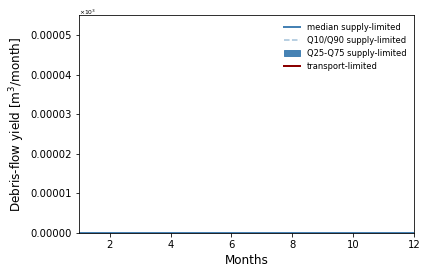

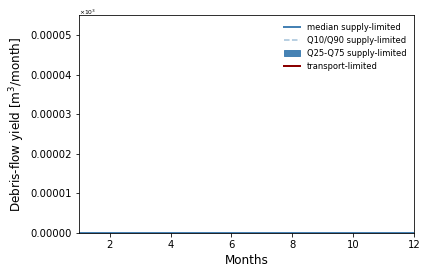

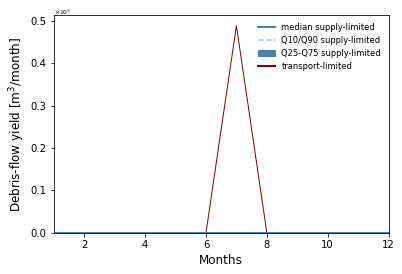

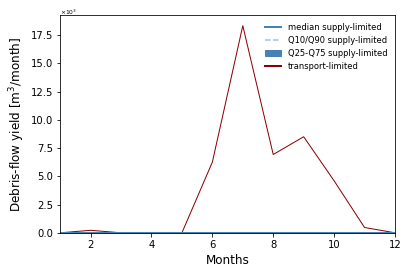

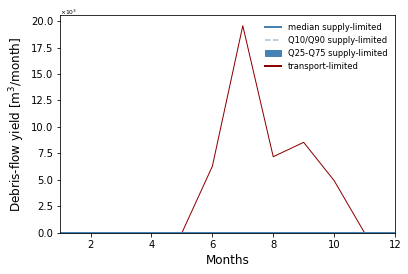

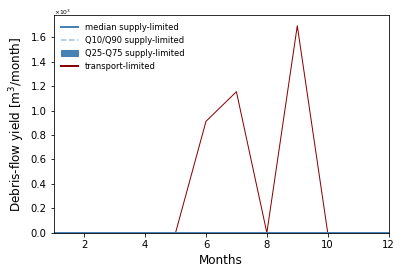

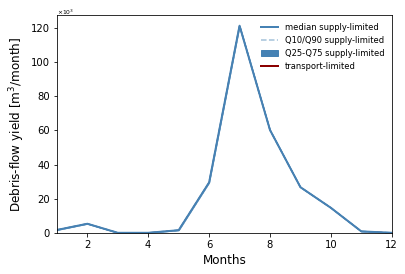

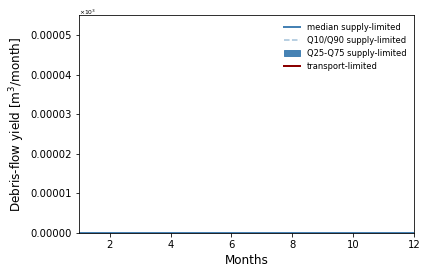

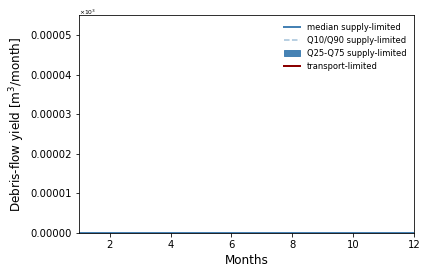

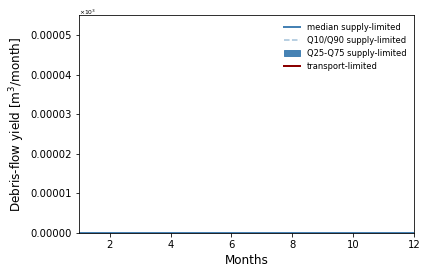

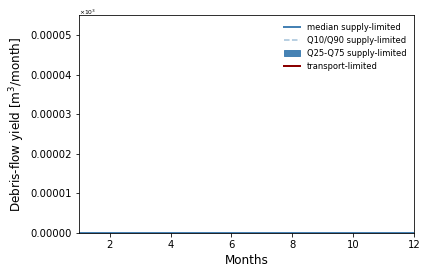

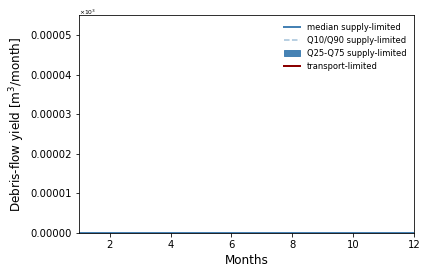

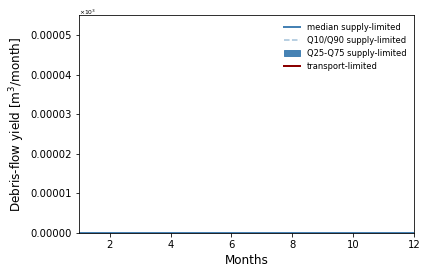

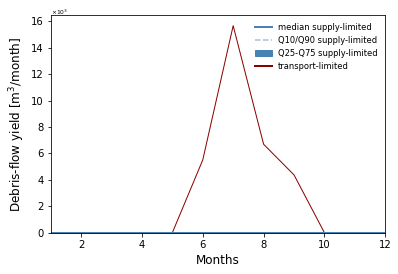

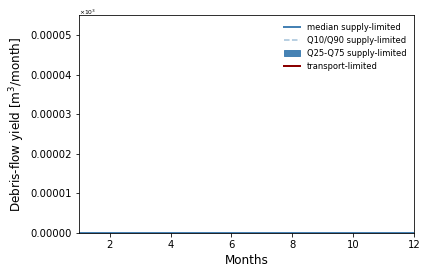

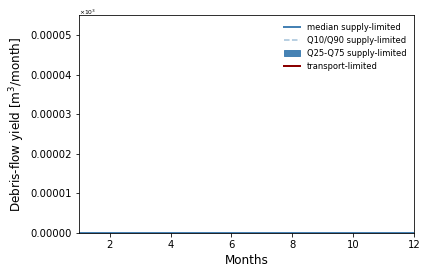

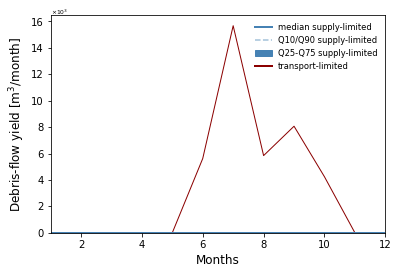

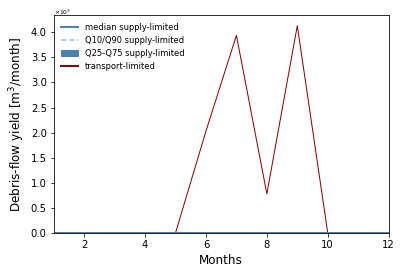

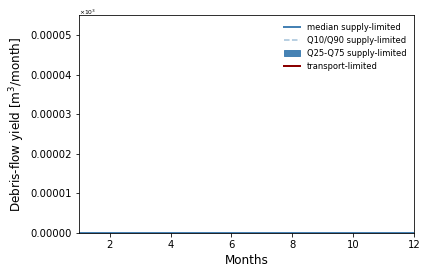

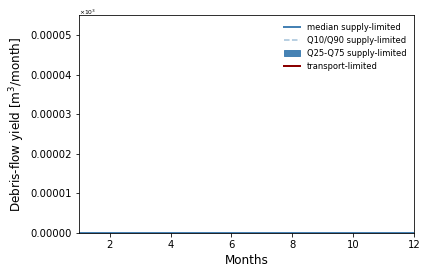

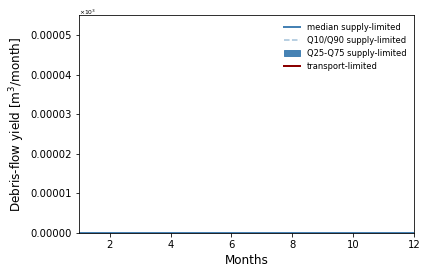

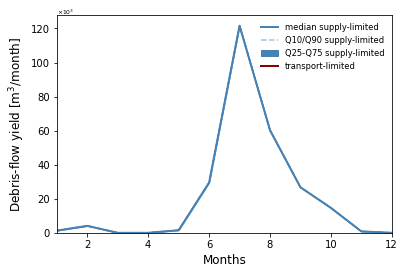

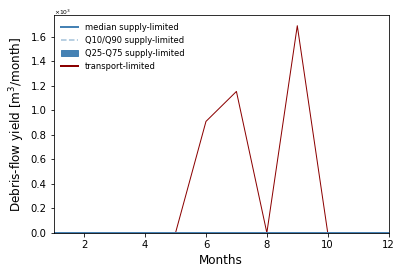

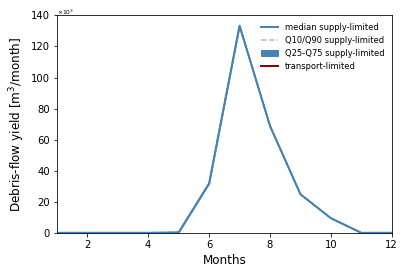

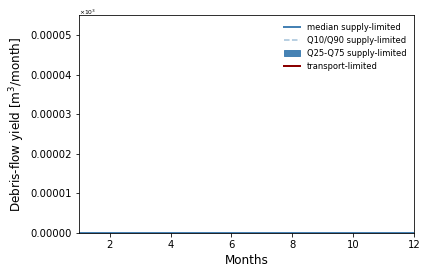

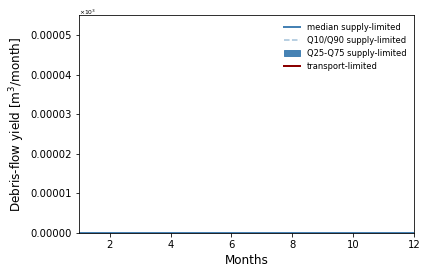

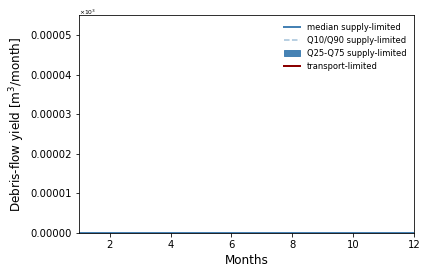

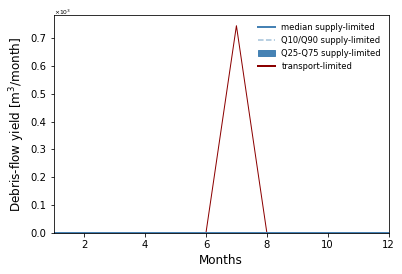

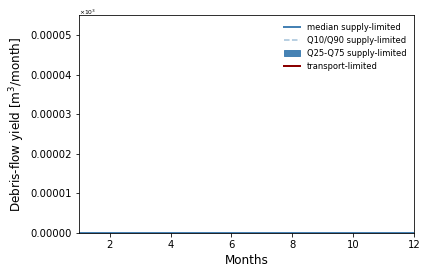

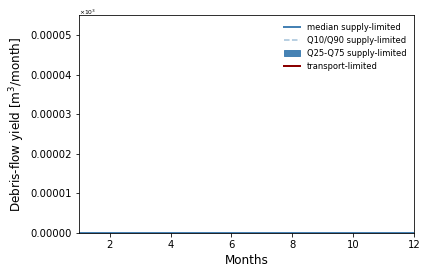

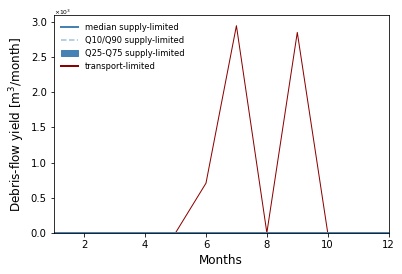

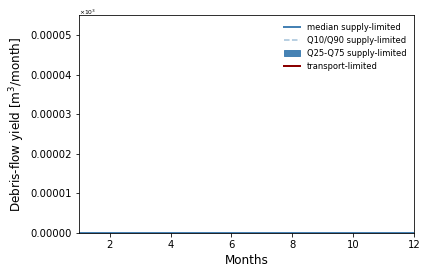

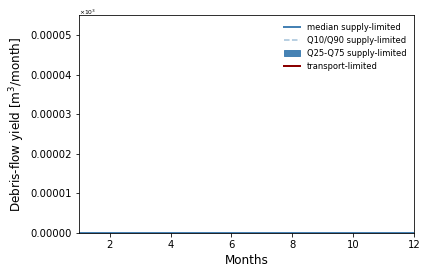

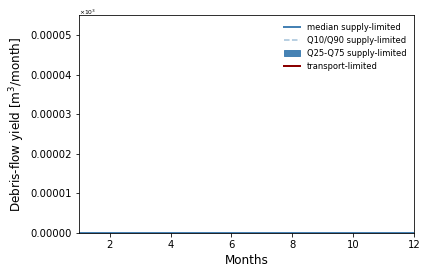

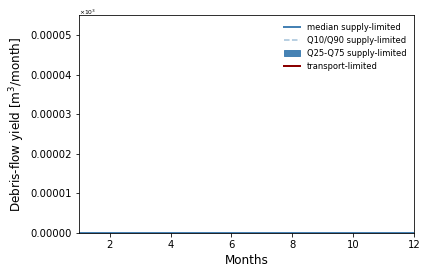

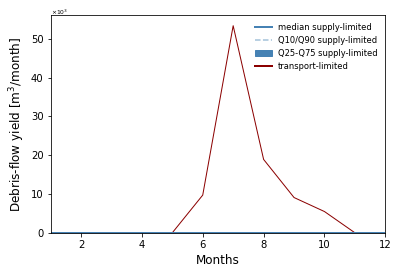

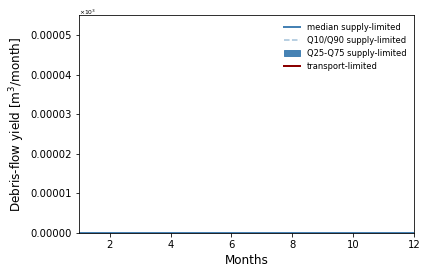

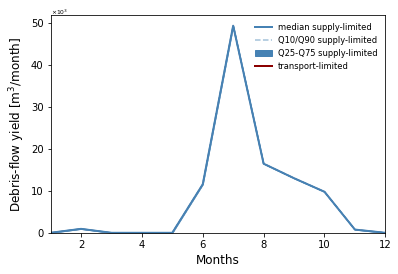

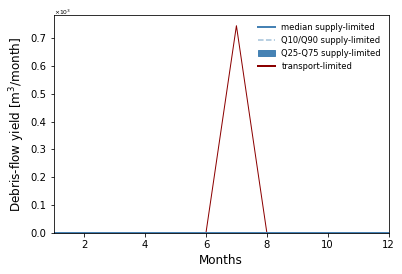

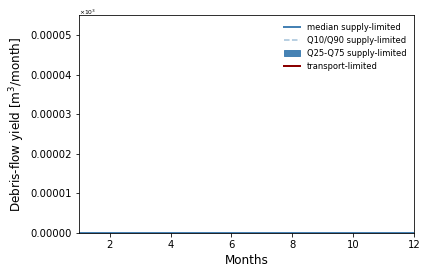

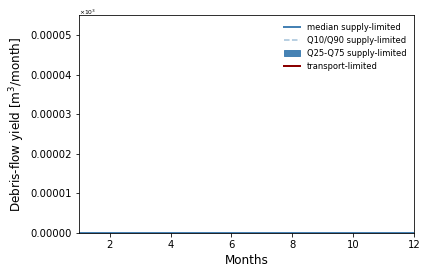

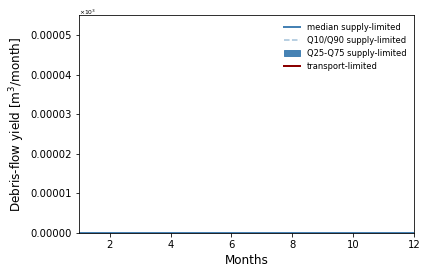

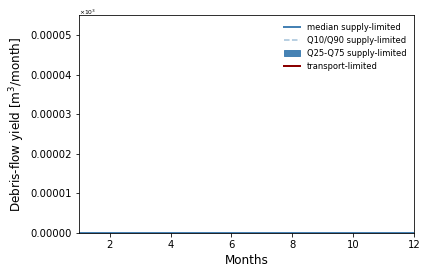

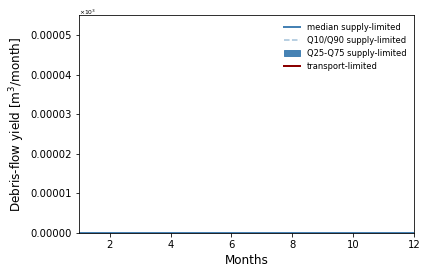

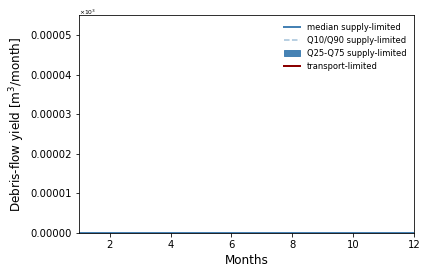

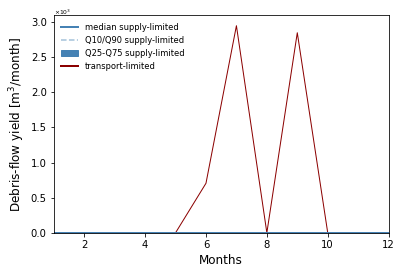

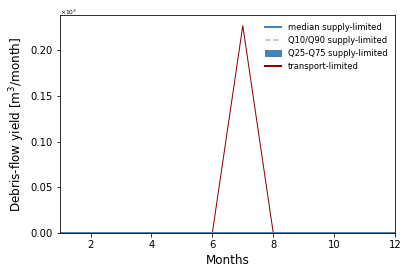

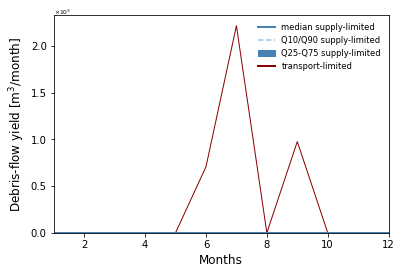

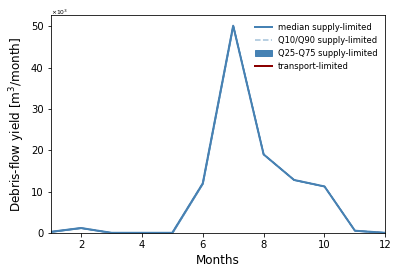

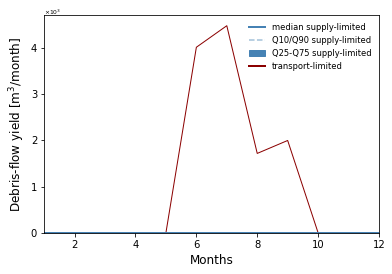

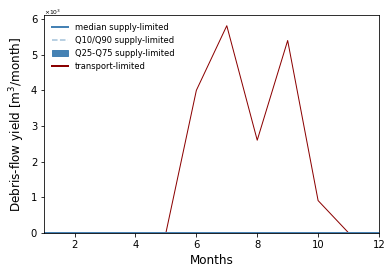

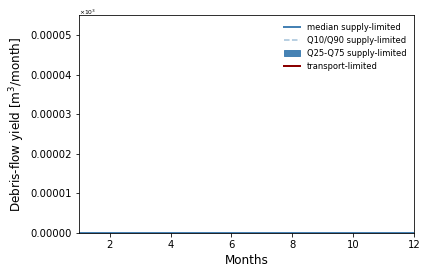

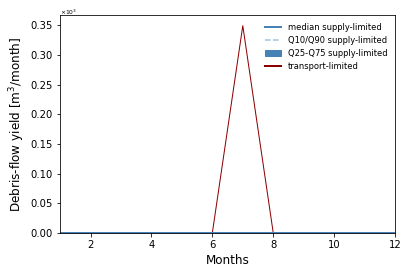

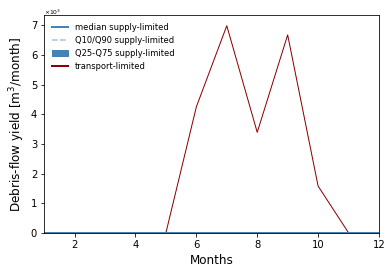

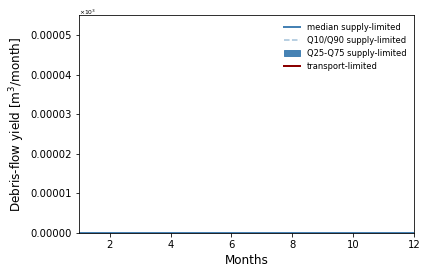

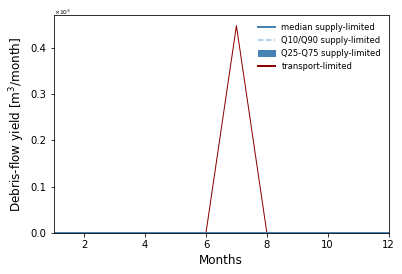

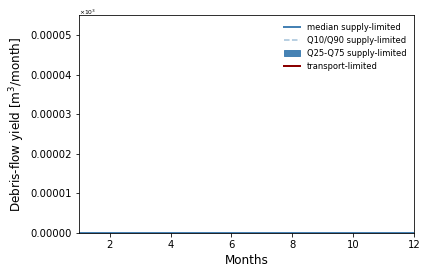

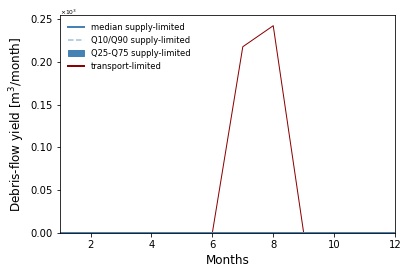

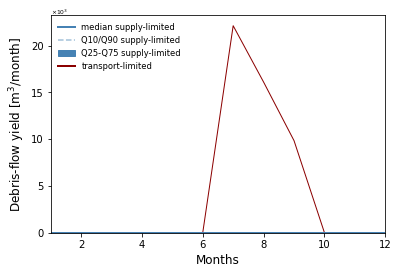

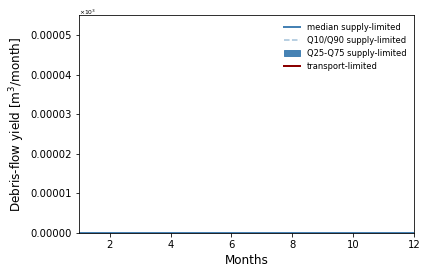

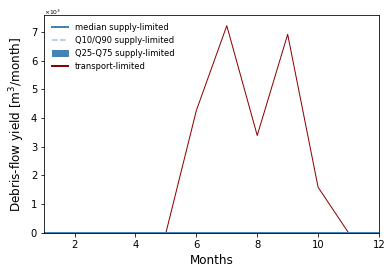

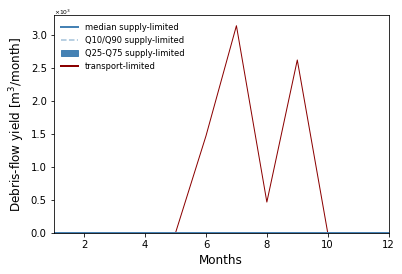

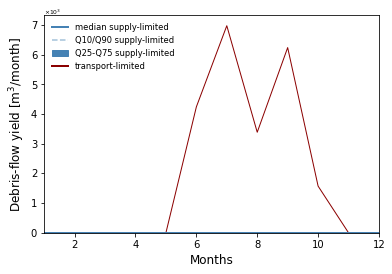

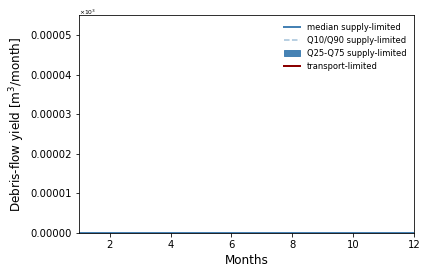

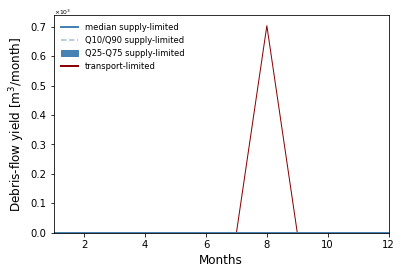

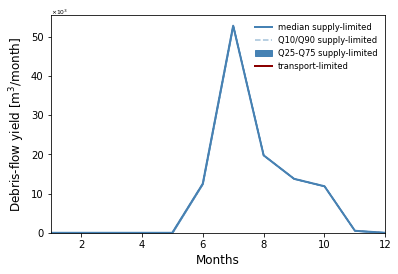

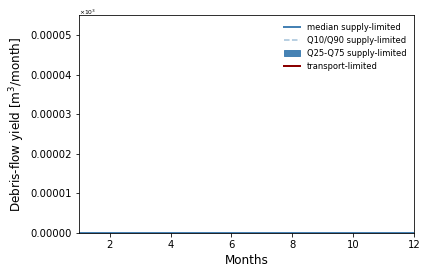

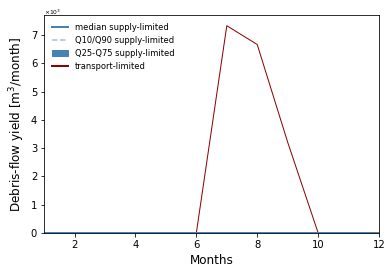

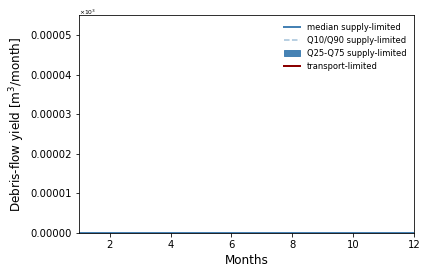

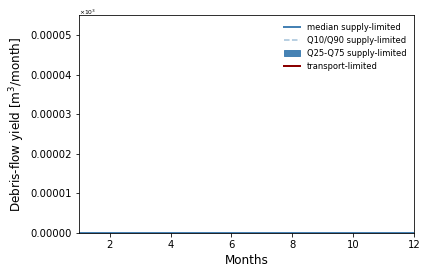

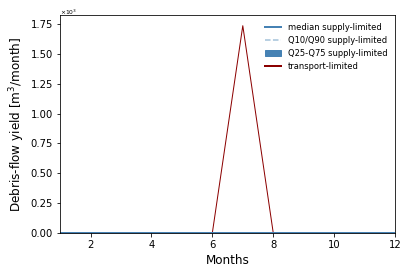

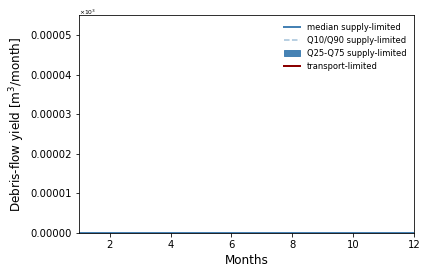

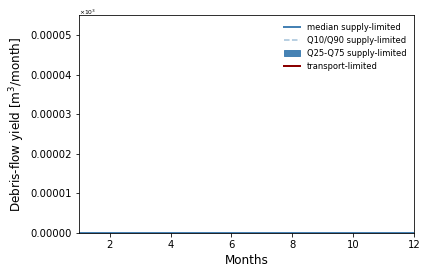

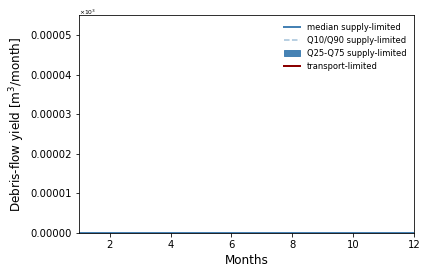

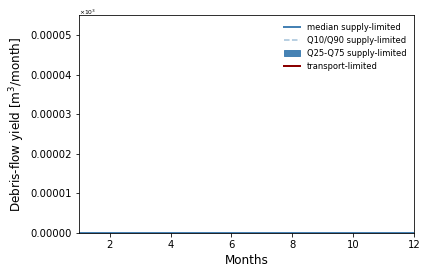

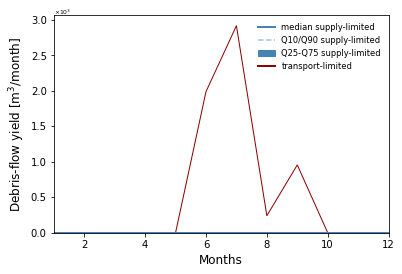

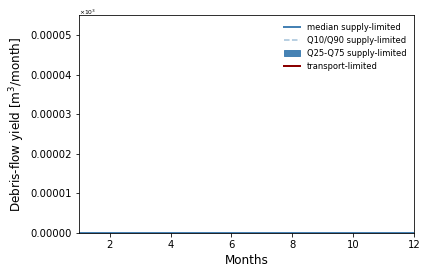

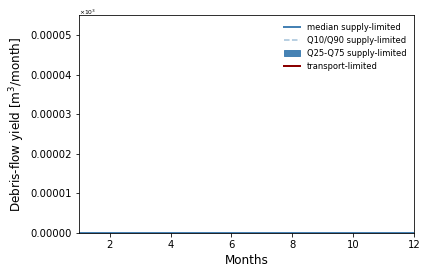

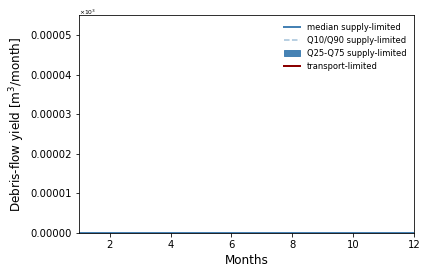

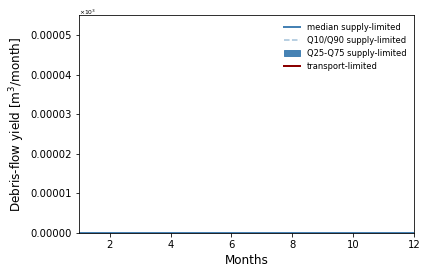

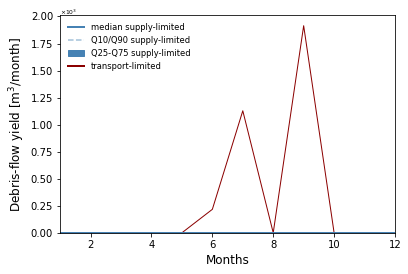

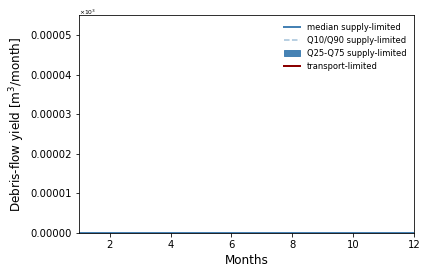

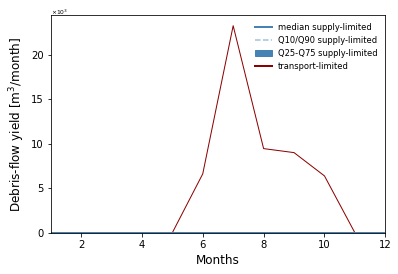

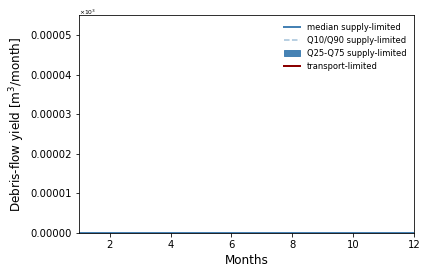

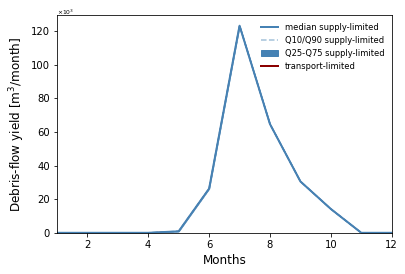

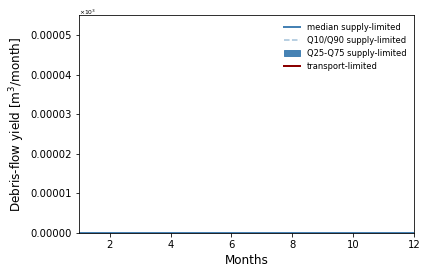

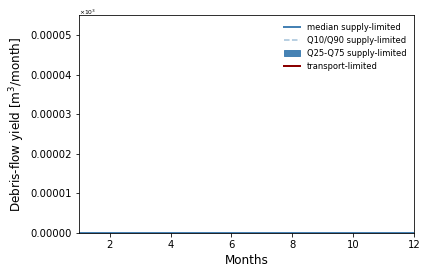

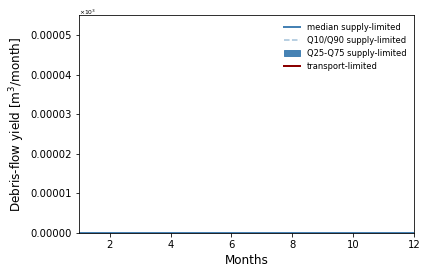

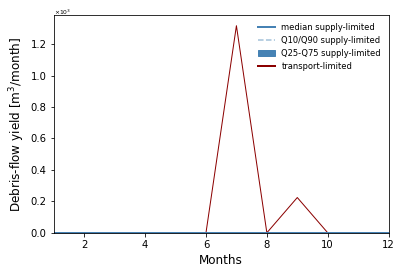

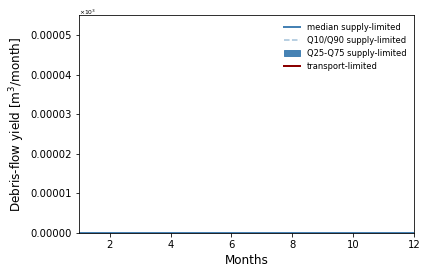

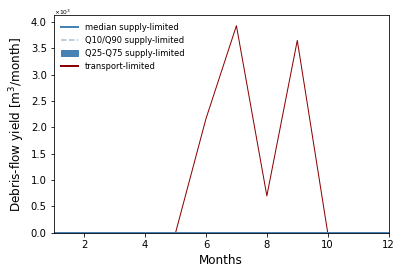

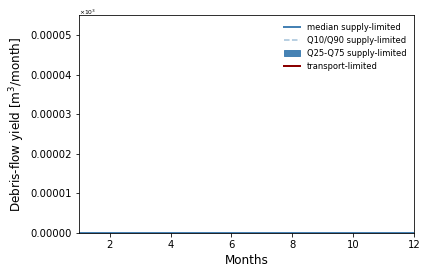

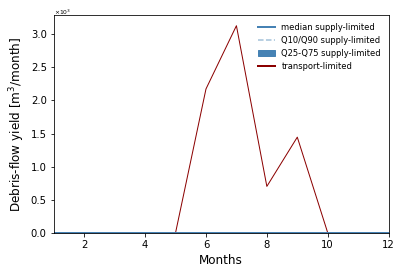

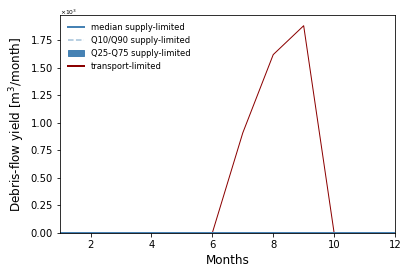

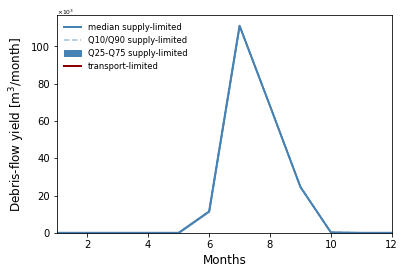

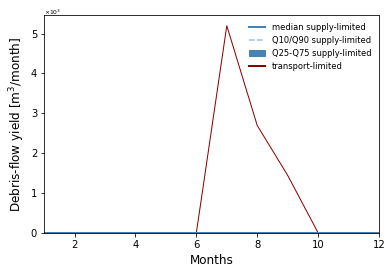

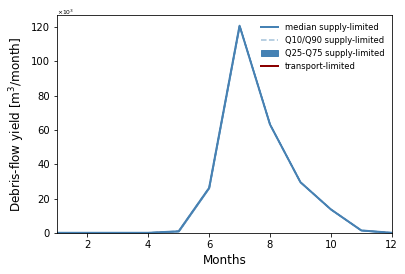

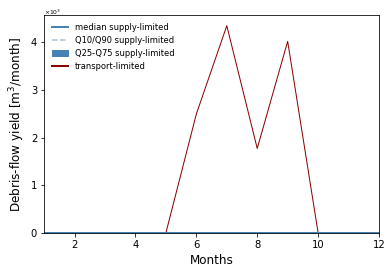

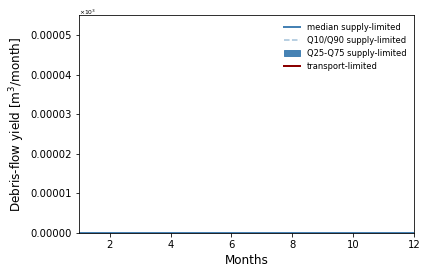

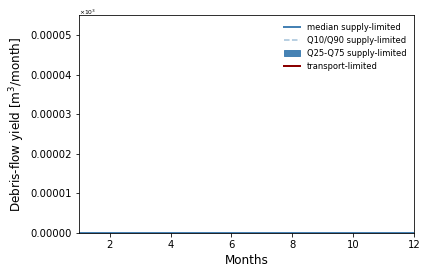

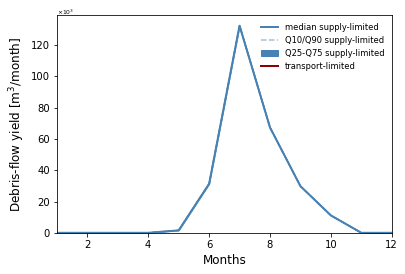

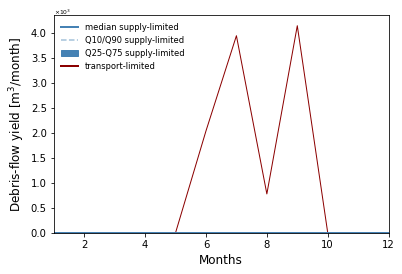

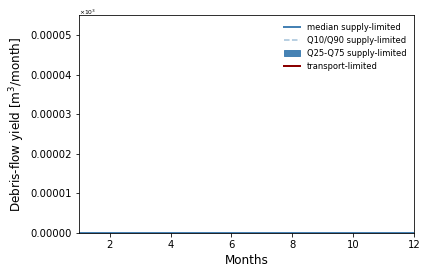

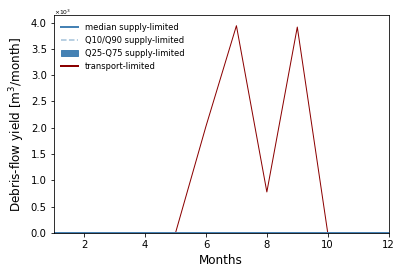

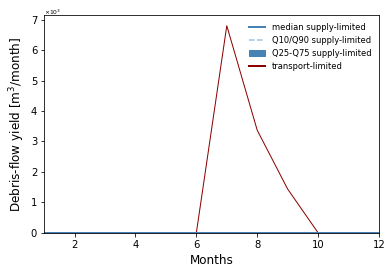

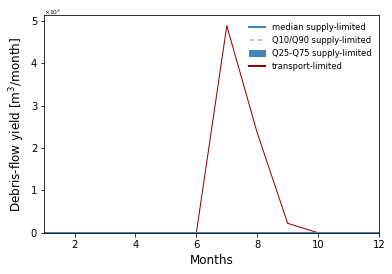

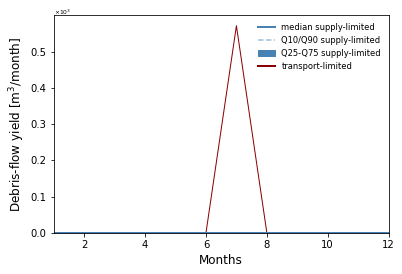

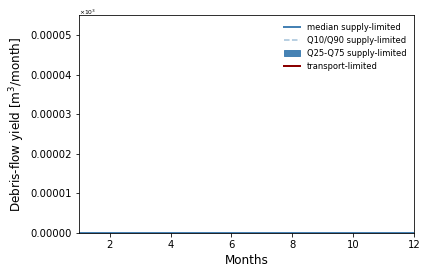

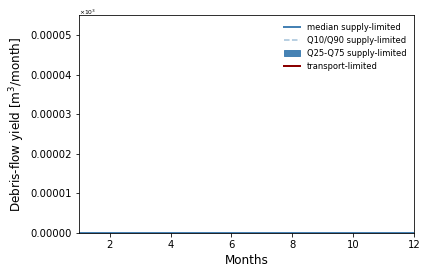

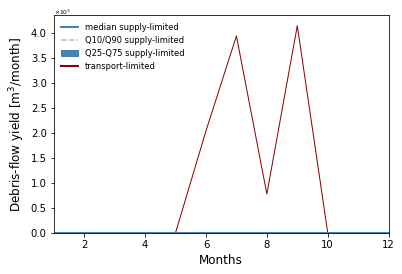

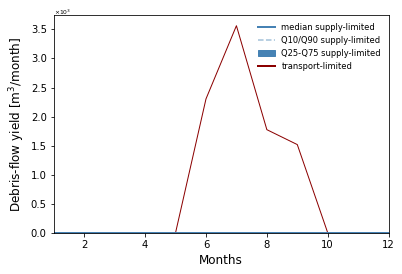

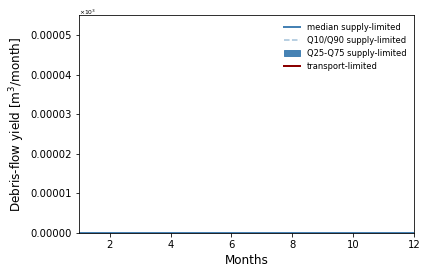

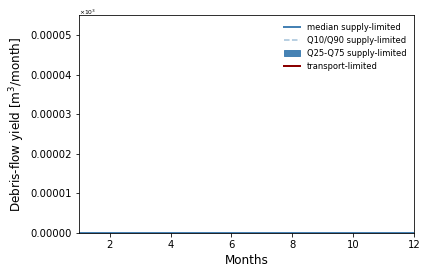

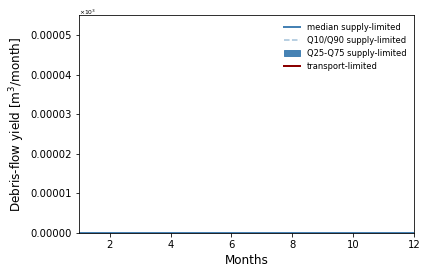

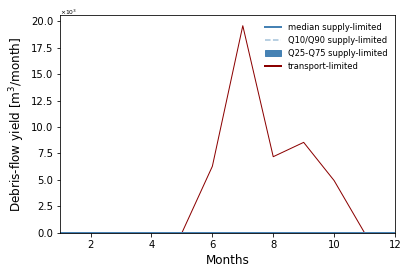

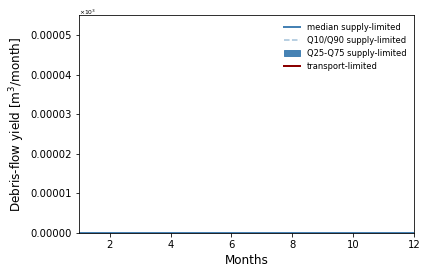

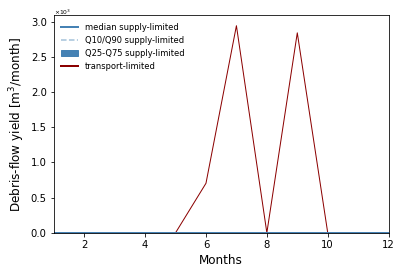

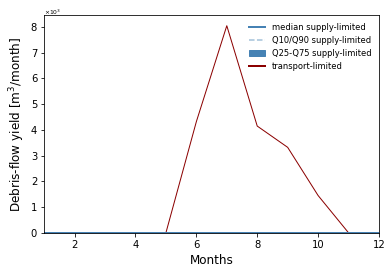

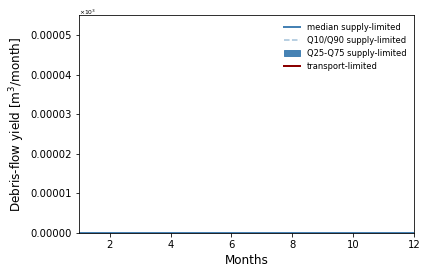

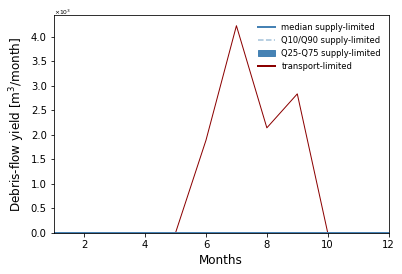

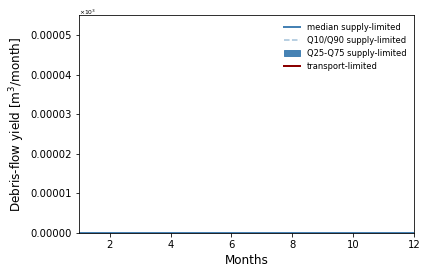

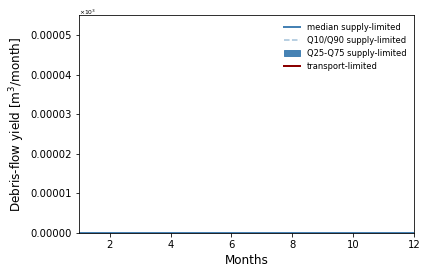

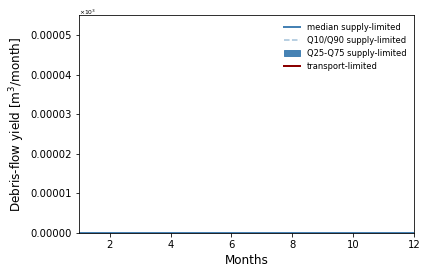

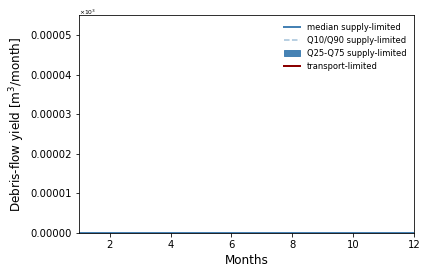

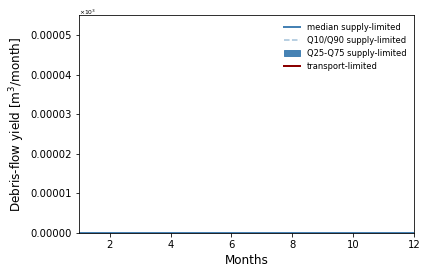

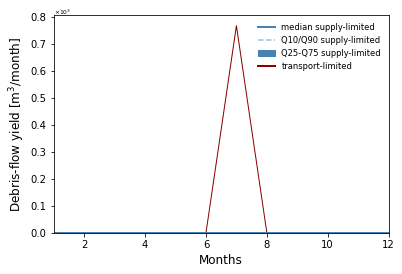

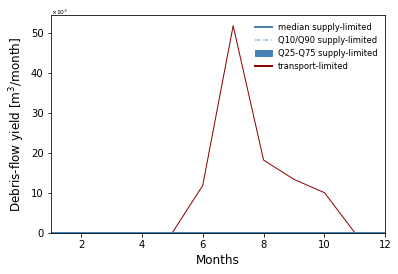

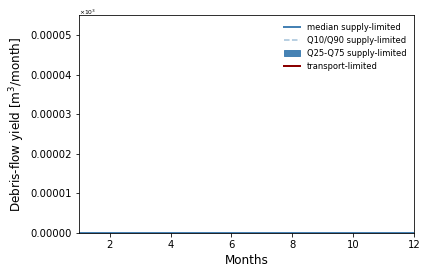

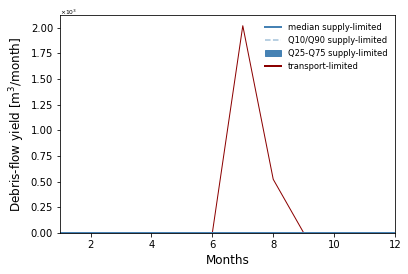

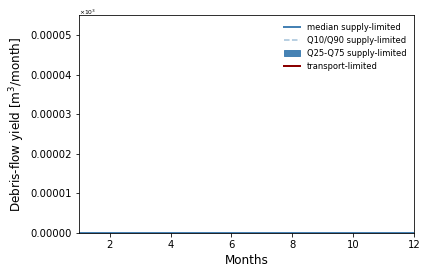

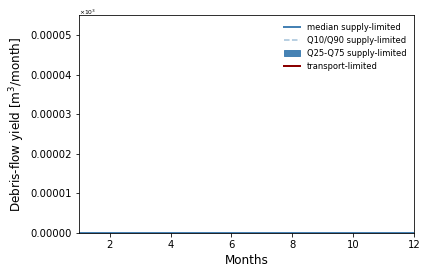

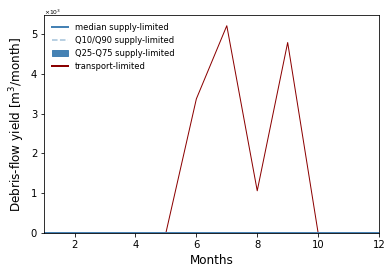

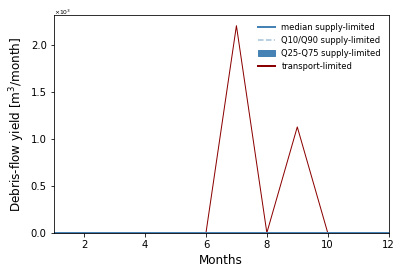

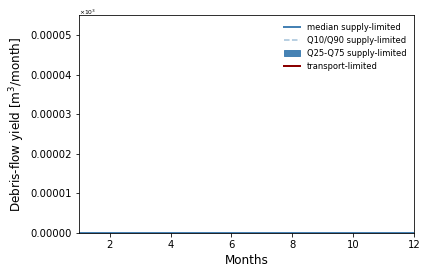

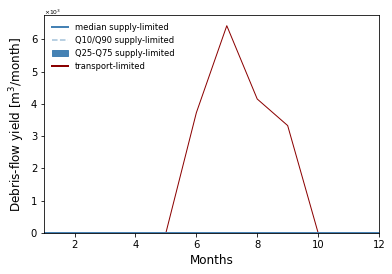

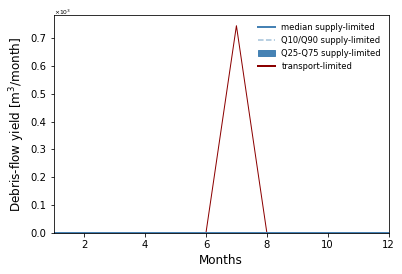

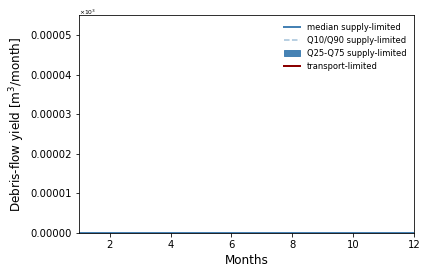

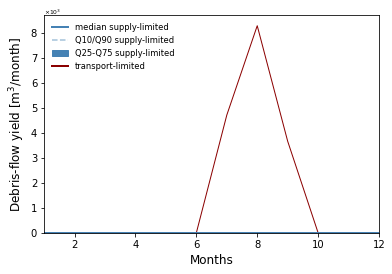

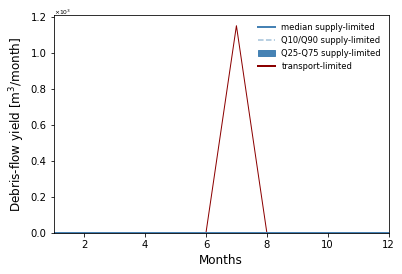

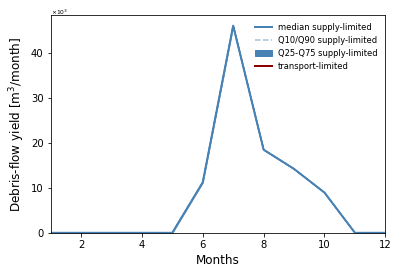

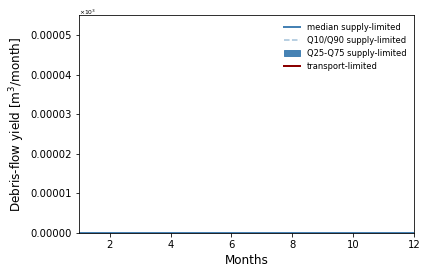

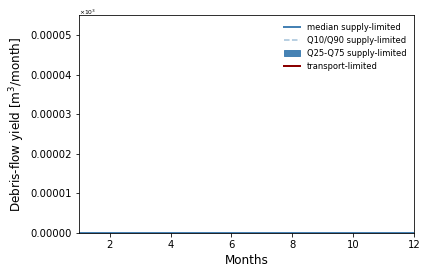

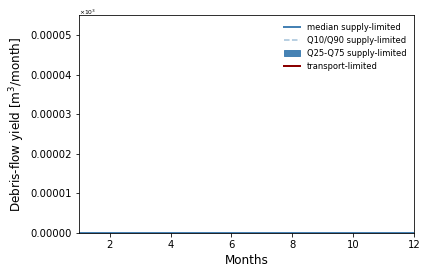

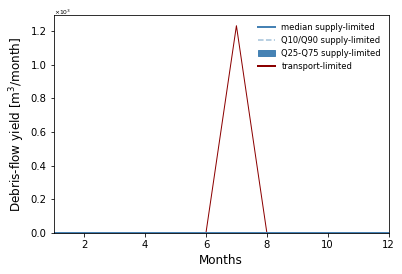

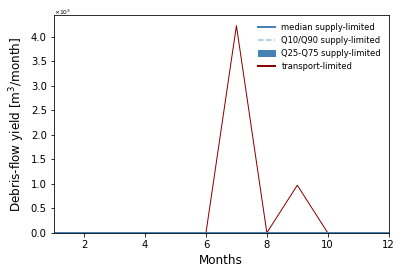

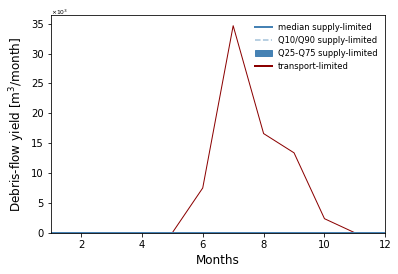

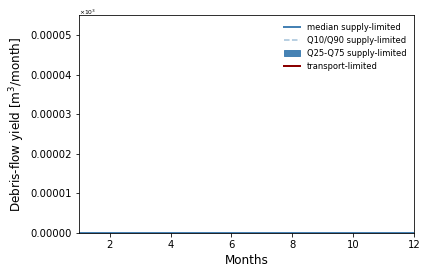

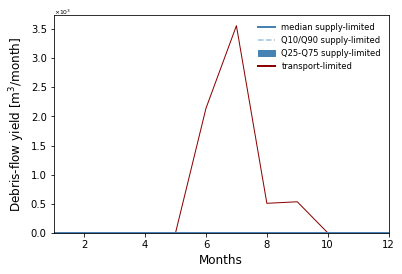

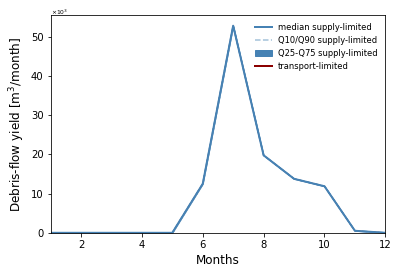

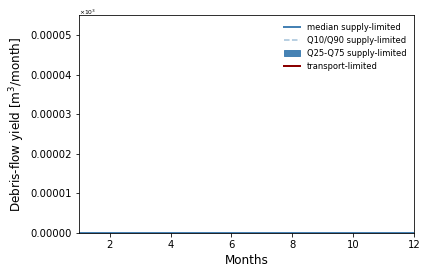

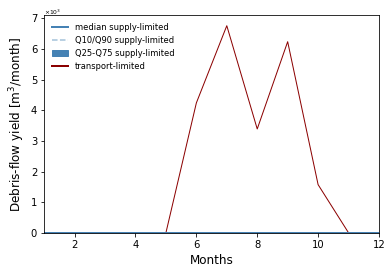

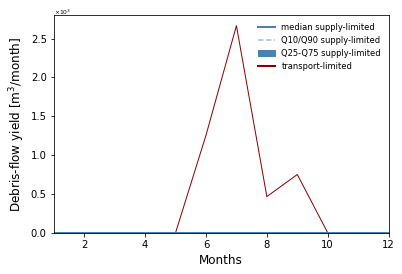

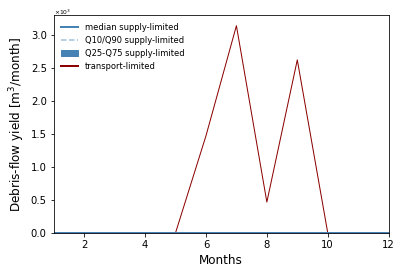

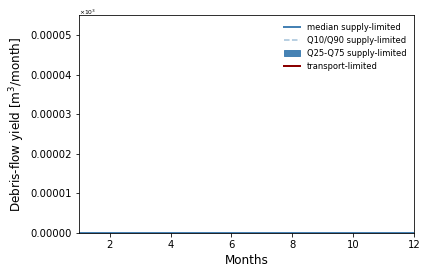

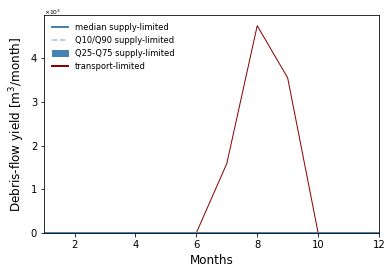

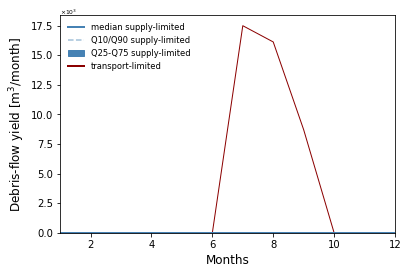

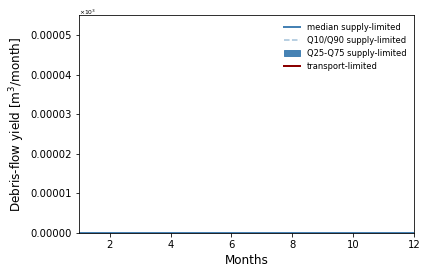

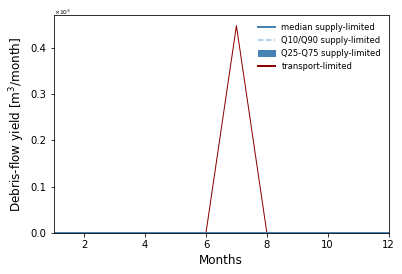

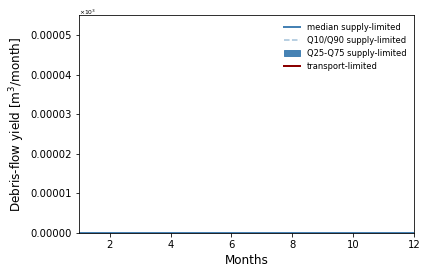

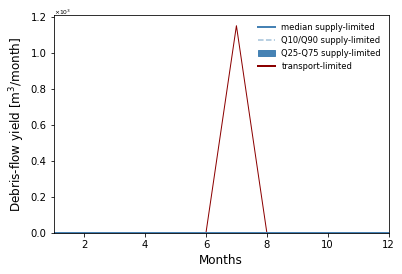

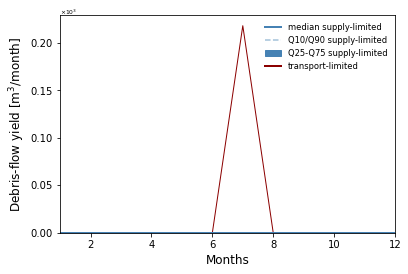

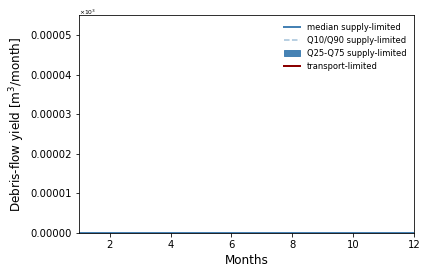

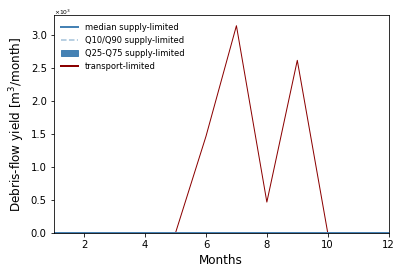

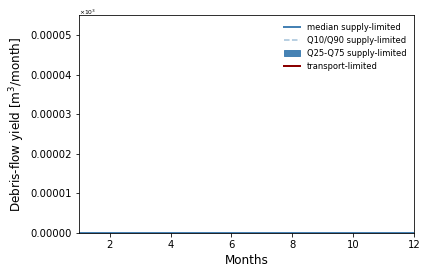

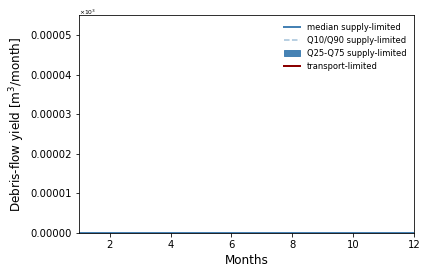

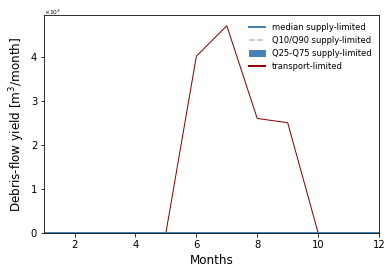

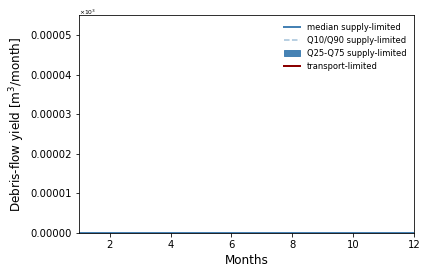

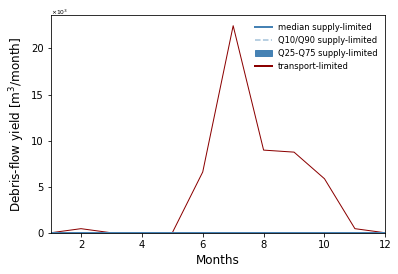

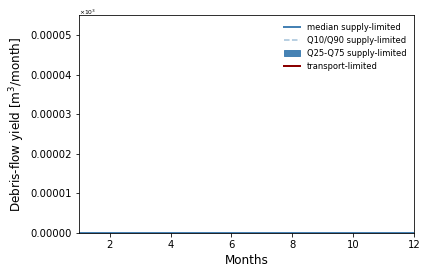

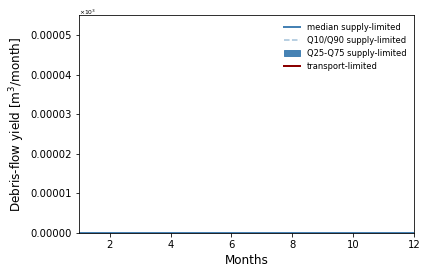

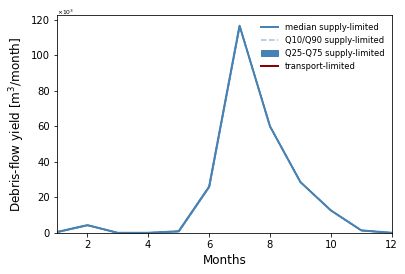

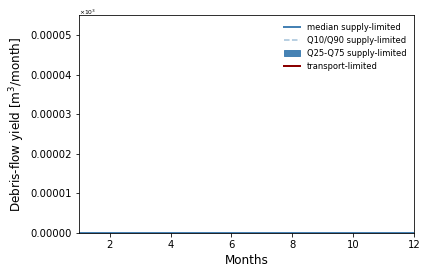

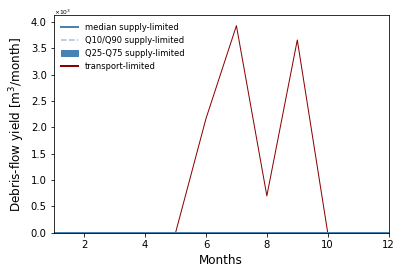

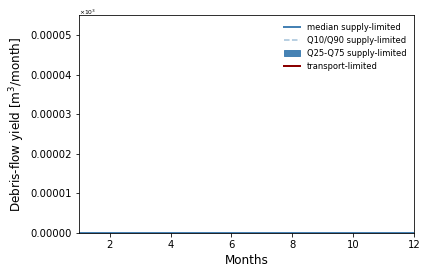

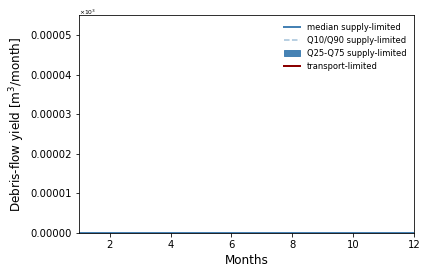

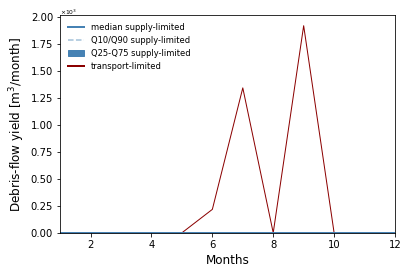

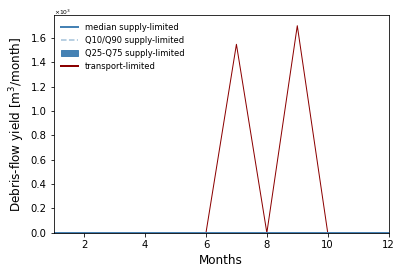

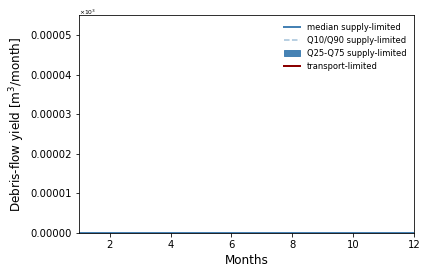

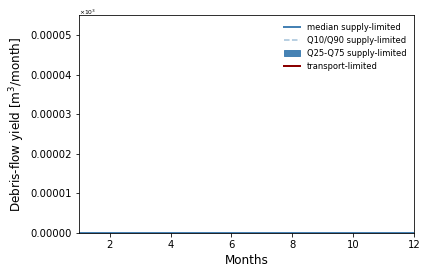

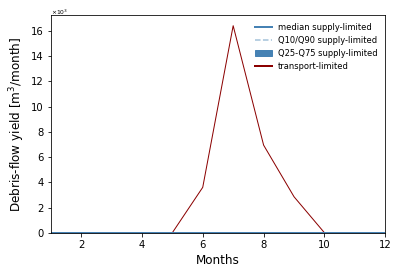

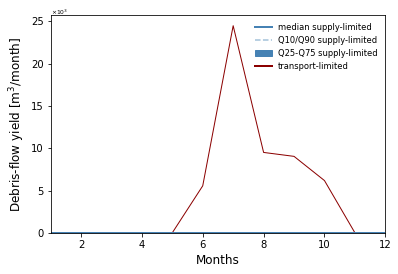

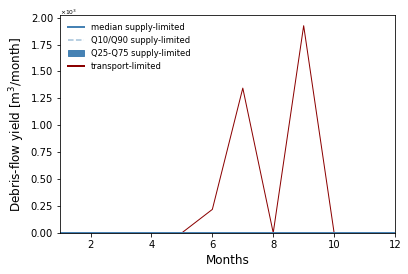

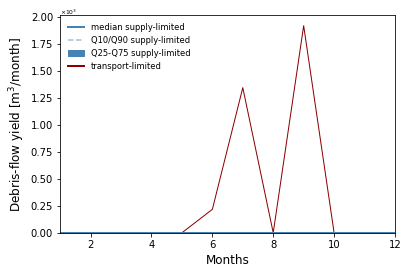

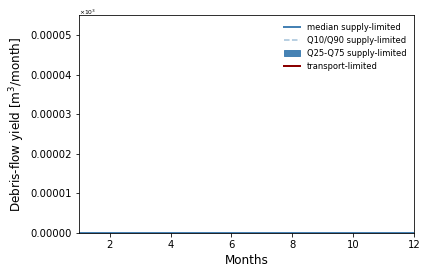

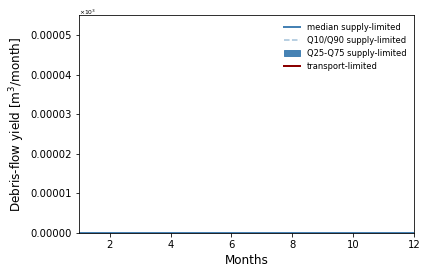

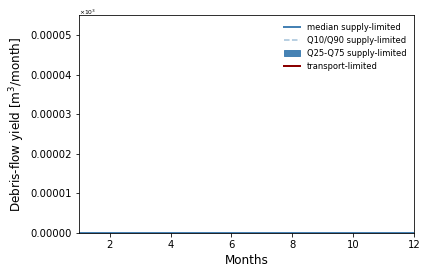

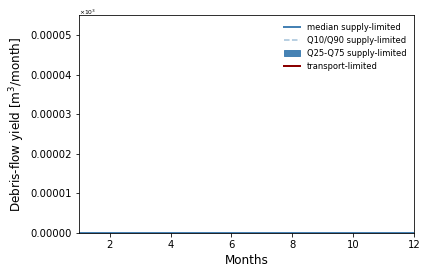

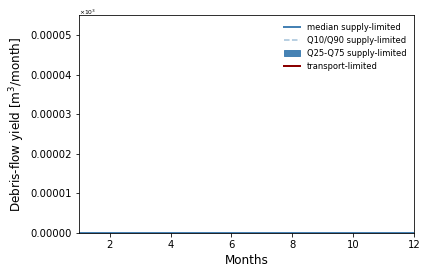

In [3]:
%%time

# NEXT - MUSTANG 25% - write params first. the data is stored on the local ssd. 
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/2bagrotSL/default_land_cover_50percent'

climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangSL/default_land_cover_25percent'

# get all folders togetehr 
# ls_ = os.listdir('./langtang')
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()

# run the model for each
for d in ls:
    path = os.path.join(dir0, '3mustangSL/default_land_cover_25percent', d)

    print(path)
    os.chdir(path)
    run()
    os.chdir(dir0)

In [ ]:
%%time
# ----- this code is for the situations, when some folders have been finished, but some not 
# -- only run for folders that do not already have sediment out file

# !! CHANGE PATH
climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/3mustangTL/default_land_cover/'

# Get all folders together
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()

# Iterate through each folder in ls
for d in ls:
    path = os.path.join(climatepath, d)  # Construct full path to the folder
    if os.path.isdir(path):  # Check if the path is a directory
        sediment_out_exists = os.path.exists(os.path.join(path, 'Sediment.out'))
        
        if not sediment_out_exists:
            # Add code to perform operations only if Sediment.out file doesn't exist
            if path.endswith('.csv'):
                continue
            os.chdir(path)
            run()
            os.chdir(dir0)
        else:
            print("already done:", path)


## 